In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import pyro.distributions as dist
import scipy as sp
import scipy.stats
import time
import torch

In [2]:
# Utilities
import scene_generation.data.planar_scene_arrangement_utils as psa_utils

# These scenes include normally randomly distributed nonpenetrating
# object arrangements with mu = 0.5, 0.5, pi and sigma=0.1, 0.1, pi/2
DATA_BASE = "../data/single_planar_box_arrangements/normal_random/fixed_2_objects"
environments = psa_utils.load_environments(DATA_BASE) 

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

Loaded 1000 train environments from file ../data/single_planar_box_arrangements/normal_random/fixed_2_objects/train.yaml
Loaded 1000 valid environments from file ../data/single_planar_box_arrangements/normal_random/fixed_2_objects/valid.yaml
Loaded 1000 test environments from file ../data/single_planar_box_arrangements/normal_random/fixed_2_objects/test.yaml


. Loss:  33.2532485613
. . . . tensor([[5.9110e-01, 4.3869e-01, 1.1437e-04, 4.2176e-03, 2.0341e-03, 3.1581e+00,
         5.0747e-01, 5.6038e-01, 3.9677e-01, 7.2112e-03, 5.8082e-03, 5.3914e+00]],
       dtype=torch.float64, grad_fn=<TBackward>)


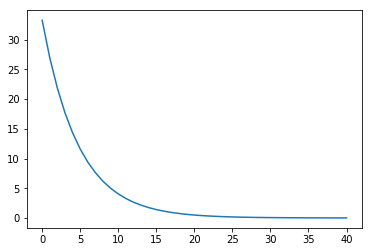

In [3]:
# Try out gradient descent through the projection operator
import scene_generation.differentiable_nlp as diff_nlp
from copy import deepcopy

device = torch.device('cpu')
env_i = environments["train"][13]

rbt, qf = psa_utils.build_rbt_from_summary(env_i)
nq = rbt.get_num_positions()
#q = torch.tensor(qf.reshape(nq, 1), requires_grad=True)
np.random.seed(1)
q_start = np.random.random([nq, 1])
q = torch.tensor(q_start, requires_grad=True, dtype=torch.double)
q_target = torch.tensor(qf).view(nq, 1)

learning_rate = 0.05
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
losses = []
q_snapshots = []
q_pred_snapshots = []
for t in range(41):
    # Scheduling on the regularization in the derivative, which helps break off of
    # constraint surfaces during the first few iterations.
    q_pred = diff_nlp.projectToFeasibilityWithIKTorch.apply(q, rbt, constraints, 1/np.log(t+2))
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (q_pred - q_target).pow(2).sum()
    losses.append(loss.cpu().detach().item())
    q_snapshots.append(q.cpu().detach().numpy().copy())
    q_pred_snapshots.append(q_pred.cpu().detach().numpy().copy())
    loss.backward()
    with torch.no_grad():
        q -= learning_rate * q.grad
        # Manually zero the gradients after running the backward pass
        q.grad.zero_()
    if t % 10 == 0:
        print ".",
    if t % 100 == 0:
        print "Loss: ", loss.cpu().detach().item()

print torch.t(q)
plt.figure()
plt.plot(losses)

In [4]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_snapshots),
                              interval=2000/len(q_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [5]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_pred_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_pred_snapshots),
                              interval=2000/len(q_pred_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

Selection of environments from prior / generative model


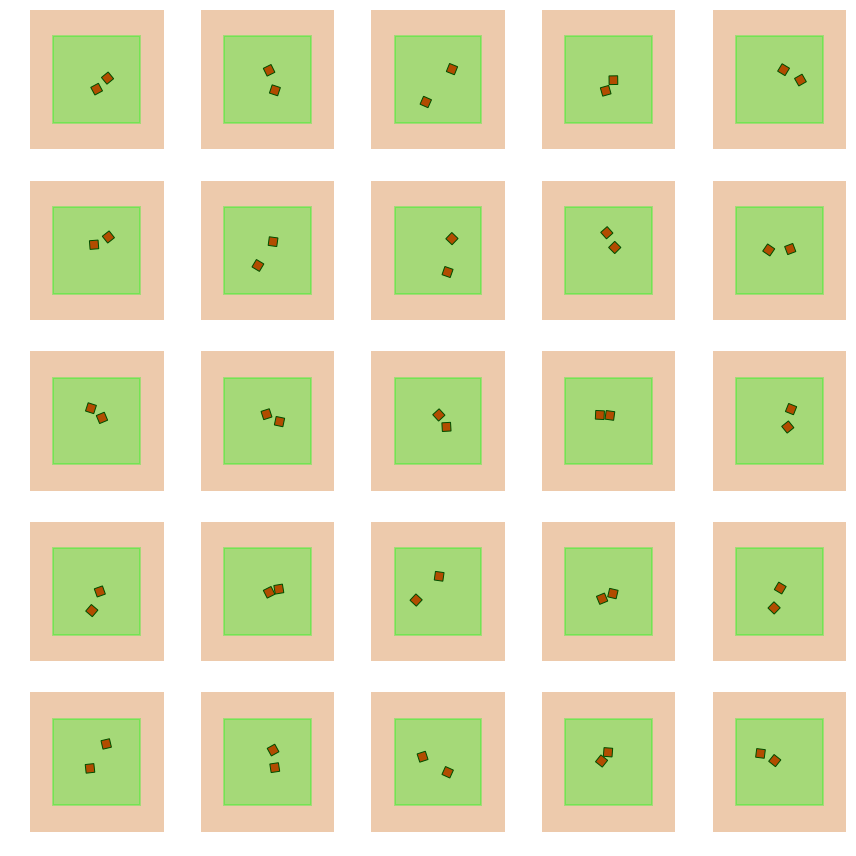

In [6]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments["train"][i*N+j+1], plt.gca())
        plt.grid(True)
plt.tight_layout()

q0:  tensor([[-0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       requires_grad=True) tensor([-27.8826], grad_fn=<AddBackward0>)
qf:  tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True) tensor([17.9585], grad_fn=<AddBackward0>)
qother:  tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) tensor([5.4585], grad_fn=<AddBackward0>)
tensor([[-0.1000, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0959, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0918, -0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0918,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0959,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1000,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000]])
q0_2:  tensor([[1.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], requires_grad=True) tensor([-27.8826], grad_fn=<AddBackward0>)
qf_2:  tensor([[1., 0., 0., 0., 0., 0.]], requires_grad=True) tensor([8.3019], grad_fn=<AddBackward0>)
qother:  tensor([[0

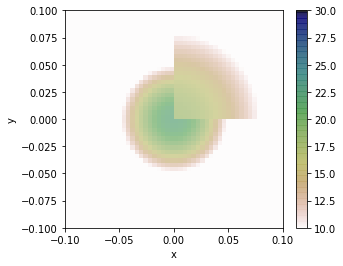

In [98]:
# Test some functionality of the custom distribution type
dummy_env = deepcopy(environments["train"][0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments["train"][0])
ik_constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
q0 = torch.tensor([[-0.1 , 0., 0., 0., 0., 0]], requires_grad=True)
distrib = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
    one_box_rbt, q0, ik_constraints, 0.02, 0.01)
qf = distrib.sample()
qother = torch.Tensor([[0.1 , 0., 0., 0., 0., 0]])
print "q0: ", q0, distrib.log_prob(q0)
print "qf: ", qf, distrib.log_prob(qf)
print "qother: ", qother, distrib.log_prob(qother)

import matplotlib as mpl
# Evaluate at many points over a 2D grid + draw likelihood out
n_points = 50
x_min = -0.1
x_max = 0.1
y_min = -0.1
y_max = 0.1
X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
q_probes = np.zeros([n_points*n_points, 6])
q_probes[:, 0] = X.flatten()
q_probes[:, 1] = Y.flatten()
q_probes = torch.tensor(q_probes, dtype=q0.dtype)
print q_probes
z = np.array([distrib.log_prob(q_probes[k, :]).detach().item() for k in range(q_probes.shape[0])])
z = z.reshape(n_points, n_points)
plt.figure()       
h = plt.gca().imshow(np.rot90(z[:, :]),
                     cmap=plt.cm.gist_earth_r,
                     extent=[x_min, x_max, y_min, y_max],
                     alpha=0.6,
                     norm = mpl.colors.Normalize(vmin=10.,vmax=30))
plt.colorbar(h,fraction=0.046, pad=0.04)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

# Eventually qother should be < qf, but > q0, even though it's the same
# distance from the constraint plane at x>0
if distrib.log_prob(qother).item() <= distrib.log_prob(q0).item():
    raise ValueError("I must not have finished this yet")

q0_2 = torch.tensor([[1.1 , 0., 0., 0., 0., 0]], requires_grad=True)
distrib = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
    two_box_rbt, q0_2, ik_constraints, 0.1, 0.01, q0_fixed=qf)
qf_2 = distrib.sample()
qother_2 = torch.Tensor([[0.9 , 0., 0., 0., 0., 0]])
print "q0_2: ", q0_2, distrib.log_prob(q0_2)
print "qf_2: ", qf_2, distrib.log_prob(qf_2)
print "qother: ", qother_2, distrib.log_prob(qother_2)
if distrib.log_prob(qother_2).item() <= distrib.log_prob(q0_2).item():
    raise ValueError("I must not have finished this yet")


In [154]:
# Ok, now deploy it in an inference context
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import config_enumerate
import torch.distributions.constraints as constraints

pyro.enable_validation(True)

class DataWrapperForObs:
    # Convenience wrapper on data:
    # If data's batch dimension is length-0,
    # we must be running the model in generative mode,
    # so any slicing returns None.
    # Otherwise, pass through slicing to the real data.
    def __init__(self, data):
        self.data = data
    def __getitem__(self, key):
        if self.data.shape[0] > 0:
            return self.data[key]
        else:
            return None
   
# Cobbling together some RBTs ahead of time for convenience
# 2-obj env
print environments["train"][0]
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments["train"][0])
# 1-obj env
dummy_env = deepcopy(environments["train"][0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
assert(two_box_rbt.get_num_positions() == 12)
assert(one_box_rbt.get_num_positions() == 6)
rbts = [one_box_rbt, two_box_rbt]
ik_constraint = [diff_nlp.object_at_specified_pose_constraint_constructor_factory(
    0, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraint_2 = ik_constraint + [
    diff_nlp.object_at_specified_pose_constraint_constructor_factory(
        1, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraints = [ik_constraint, ik_constraint_2]

def expand_partial_pose_to_full_pose(this_pose):
    if this_pose is None:
        return this_pose
    full_poses = torch.zeros(this_pose.shape[0], 6,
                             requires_grad=False,
                             dtype=this_pose.dtype)
    full_poses[:, 0] = this_pose[:, 0]
    full_poses[:, 1] = this_pose[:, 1]
    full_poses[:, 5] = this_pose[:, 2]
    return full_poses

def collapse_full_pose_to_partial_pose(pose):
    if pose is None:
        return None
    partial_pose = torch.zeros(pose.shape[0], 3, requires_grad=False,
                       dtype=pose.dtype)
    partial_pose[:, 0] = pose[:, 0]
    partial_pose[:, 1] = pose[:, 1]
    partial_pose[:, 2] = pose[:, 5]
    return partial_pose

# Sample an exactly 2-object environment
# "data" is either None (run in generative mode),
# or is n_batches x 6 (environment pose vectors)
N_OBJECTS = 2
def model(data = torch.Tensor(0, 12), use_projection=True, subsample_size=None,
          noisy_projection=False, use_amortization=True):
    if data.shape[1] != 12:
        raise ValueError("Expected data to have n_batches x 12 shape.")
    
    # Object placement distribution is shared across objects
    # (maybe switch this to Normal-inverse-Wishart_distribution, if supported?)
    # Normal distributions are specified by standard deviation (scale),
    # but multivariate normals by covariance matrix. :P
    box_mean = pyro.sample('box_mean', dist.Normal(
        torch.Tensor([0.5, 0.5, np.pi]), torch.Tensor([0.5, 0.5, np.pi/2.])).to_event(1))
    box_var = pyro.sample('box_var', dist.LogNormal(
        torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([2.0, 2.0, 2.0])).to_event(1))
    box_dist = dist.MultivariateNormal(box_mean, torch.diag(box_var))
    
    data_batch_size = max(1, data.shape[0])
    with pyro.plate('data', size=data_batch_size) as ind:
        generated_data = torch.zeros(ind.shape[0], 3*N_OBJECTS)
        if data.shape[0] > 0:
            data_obs = DataWrapperForObs(data[ind, :])
        else:
            data_obs = DataWrapperForObs(data[:, :])
        
        
        last_scene_configs = []
        for k in range(N_OBJECTS):
            if use_projection:
                new_pose = pyro.sample("box_%d_pre_pose" % k, box_dist)
                q0_fixed = None
                if len(last_scene_configs) > 0:
                    q0_fixed = torch.cat(last_scene_configs)
                #projection_dist = dist.Normal(new_pose, 0.01*torch.ones(new_pose.shape)).to_event(1)
                #projected_pose = pyro.sample("box_%d_pose" % k, projection_dist,
                #                             obs=collapse_full_pose_to_partial_pose(data_obs[:, (k*6):(k*6+6)]))
                #generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
                #last_scene_configs.append(projected_pose)
                #continue
                
                #TODO: OK, this problem is that this is sampling in 6D, while  the guide
                #    is sampling in 3D, so the densities are too different.
                #    Yuck
                projection_dist = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
                    rbts[k], expand_partial_pose_to_full_pose(new_pose),
                    ik_constraints[k], 0.05, 0.01, noisy_projection=noisy_projection,
                    q0_fixed=q0_fixed, event_select_inds=torch.tensor([0, 1, 5]))
                projected_pose = pyro.sample("box_%d_pose" % k, projection_dist,
                                             obs=collapse_full_pose_to_partial_pose(data_obs[:, (k*6):(k*6+6)]))
                generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
                last_scene_configs.append(expand_partial_pose_to_full_pose(projected_pose))
            else:
                projected_pose = pyro.sample("box_%d_pose" % k, box_dist, obs=data_obs[:, [k*6, k*6+1, k*6+5]])
                generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
    
    return generated_data

H = 10
inference_module = torch.nn.Sequential(
  torch.nn.Linear(6, H),
  torch.nn.ReLU(),
  torch.nn.Linear(H, 3),
)

def guide(data = torch.Tensor(1, 12), use_projection=True, subsample_size=None,
          noisy_projection=False, use_amortization=True):
    if data.shape[1] != 12:
        raise ValueError("Expected data to have n_batches x 12 shape.")
    if data.shape[0] == 0:
        raise ValueError("Data must have at least one entry.")

    # Intentionally wrong initialization
    est_box_mean = pyro.param('auto_box_mean', torch.tensor([0.25, 0.25, np.pi/2.]))
    est_box_mean_var = pyro.param('auto_box_mean_var', torch.tensor([0.1, 0.1, 0.1]),
                                  constraint=constraints.positive)
    est_box_var = pyro.param('auto_box_var', torch.tensor([0.1, 0.1, 0.5]),
                         constraint=constraints.positive)
    box_mean = pyro.sample("box_mean", dist.Normal(est_box_mean, est_box_mean_var).to_event(1))
    box_var = pyro.sample("box_var", dist.Delta(est_box_var).to_event(1))
    
    if use_projection:
        box_projection_var = pyro.param("auto_box_proj_var", torch.tensor([0.1, 0.1, 0.1]),
                                        constraint=constraints.positive)
        if use_amortization:
            pyro.module("inference_module", inference_module)
        else:
            box_pre_poses = []
            for k in range(N_OBJECTS):
                box_pre_poses.append(pyro.param('auto_box_%d_pre_poses' % k,
                                     torch.randn(data.shape[0], 3)*0.5 + 0.5))

    with pyro.plate('data', size=data.shape[0], subsample_size=subsample_size) as ind:
        for k in range(N_OBJECTS):
            if use_projection:
                if use_amortization:
                    #print "Input: ", data[ind, (k*6):(k*6+6)]
                    #print "Output base ", collapse_full_pose_to_partial_pose(
                    #            data[ind, (k*6):(k*6+6)])
                    #print "Output residual: ", inference_module(data[ind, (k*6):(k*6+6)])
                    predicted_pre_pose_base = collapse_full_pose_to_partial_pose(
                        data[ind, (k*6):(k*6+6)])
                    predicted_pre_pose_residual = inference_module(data[ind, (k*6):(k*6+6)])
                    # Normal vs delta choice here makes a big impact on the resulting
                    # ELBO scaling. Having all deltas means the guide LL is always 0 (since
                    # when we sample forward through the guide, we'll deterministically
                    # pick the same thing with prob 1). Having normal adds noise to the
                    # guide distrib + gives the guide positive LL, which decreases the ELBO
                    # and increases the loss. Here I'm currently picking a normal distrib
                    # that is the same rough scale as the projection distribution,
                    # to make the ELBO sit right above zero. But this is super arbitrary?
                    new_pose = pyro.sample(
                        "box_%d_pre_pose" % k,
                        dist.Normal(predicted_pre_pose_base + predicted_pre_pose_residual,
                                    box_projection_var).to_event(1))
                else:
                    new_pose = pyro.sample(
                        "box_%d_pre_pose" % k,
                        dist.Normal(box_pre_poses[k][ind, :],
                                    box_projection_var).to_event(1))

pyro.clear_param_store()
trace = poutine.trace(model).get_trace()
trace.compute_log_prob()
print "MODEL WITH NO ARGS"
#print(trace.format_shapes())

pyro.clear_param_store()
trace = poutine.trace(model).get_trace(torch.zeros(10, 12), use_projection=True, subsample_size=5, use_amortization=True)
trace.compute_log_prob()
print "MODEL WITH ARGS"
#print(trace.format_shapes())

pyro.clear_param_store()
trace = poutine.trace(guide).get_trace(torch.zeros(10, 12), use_projection=True, subsample_size=5)
trace.compute_log_prob()
print "GUIDE WITH ARGS"
#print(trace.format_shapes())


{'obj_0000': {'pose': [0.5752469347880516, 0.530754330429775, 4.438867324414527], 'class': 'small_box'}, 'obj_0001': {'pose': [0.48573874018675045, 0.4177470040517661, 1.5902096655773568], 'class': 'small_box'}, 'n_objects': 2}
MODEL WITH NO ARGS
MODEL WITH ARGS
GUIDE WITH ARGS


In [21]:
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y 0 0 0 theta) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, 2*6)
    poses[:, :] = 0.
    for i, env in enumerate(envs):
        for k in range(2):
            obj = env["obj_%04d" % k]
            poses[i, (k*6):(k*6+6)][[0, 1, 5]] = torch.Tensor(obj["pose"])
    return poses
    
def devectorize_environments(data):
    envs = []
    for i in range(data.shape[0]):
        env = {}
        n_objects = 0
        for k in range(2):
            obj = {
                "pose": data[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": "small_box"
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = 2
        envs.append(env)
    return envs

# Make sure we can run model + condition on this dataset
model(vectorize_environments(environments["train"]), subsample_size=20, use_projection=True)

tensor([[0.5752, 0.5308, 4.4389, 0.4857, 0.4177, 1.5902],
        [0.4981, 0.3897, 0.4944, 0.6238, 0.5170, 3.8267],
        [0.5859, 0.3760, 4.3905, 0.5189, 0.6068, 5.1698],
        ...,
        [0.2066, 0.3658, 2.1923, 0.4542, 0.4076, 4.4863],
        [0.5485, 0.3196, 3.0816, 0.5074, 0.6245, 1.9341],
        [0.4332, 0.4803, 2.4533, 0.6387, 0.3564, 2.7931]])

In [10]:
# Some statistics over what we expect of environment mean + var
data = vectorize_environments(
    environments["train"] + environments["valid"] + environments["test"]
).detach().numpy()
print "Mean postures: ", np.mean(data, axis=0)
print "std postures: ", np.std(data, axis=0)
print "log-std postures: ", np.log(np.std(data, axis=0))
print "var postures: ", np.square(np.std(data, axis=0))

Mean postures:  [0.50397    0.49839815 0.         0.         0.         3.1935744
 0.49596503 0.5023129  0.         0.         0.         3.1272786 ]
std postures:  [0.1080094  0.10776904 0.         0.         0.         1.5988106
 0.10612138 0.10396446 0.         0.         0.         1.5661929 ]
log-std postures:  [-2.225537   -2.2277648         -inf        -inf        -inf  0.46925995
 -2.2431717  -2.2637062         -inf        -inf        -inf  0.44864774]
var postures:  [0.01166603 0.01161417 0.         0.         0.         2.5561953
 0.01126175 0.01080861 0.         0.         0.         2.45296   ]


/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Selection of environments from prior / generative model


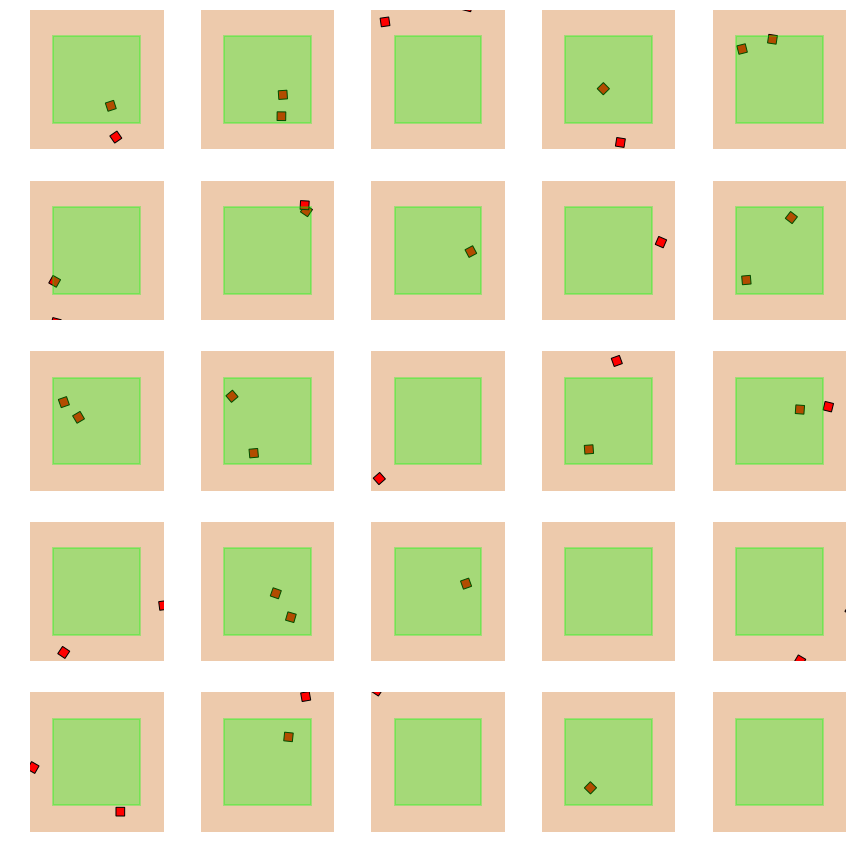

In [11]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(
            poutine.condition(model, data={"box_var": torch.Tensor([0.25, 0.25, 3.1415]),
                                           "box_mean": torch.Tensor([0.5, 0.5, 3.1415])})())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

Notes on SVI performance:

Using noisy projection didn't seem to have an important impact on SVI.

In [155]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
import pyro.optim
import torch.optim

pyro.enable_validation(True)

interesting_params = ["auto_box_mean", "auto_box_var", "auto_box_mean_var", "auto_box_proj_var"]
def select_interesting(guide):
    #all_params = guide.median()
    return dict((p, pyro.param(p).cpu().detach().numpy()) for p in interesting_params)

pyro.clear_param_store()
#global_guide = AutoDelta(
#    poutine.block(model, hide=["obs"]))
#    #poutine.block(model, expose=interesting_params))
optimizer = torch.optim.Adam
def per_param_args(module_name, param_name):
    if module_name == 'inference_module':
        return {"lr": 0.01, 'betas': [0.9, 0.99]}
    else:
        return {'lr': 0.1, 'betas': [0.9, 0.99]}
scheduler = pyro.optim.StepLR(
    {"optimizer": optimizer,
     'optim_args': per_param_args,
     'gamma': 0.25, 'step_size': 100})
elbo = Trace_ELBO(max_plate_nesting=1, num_particles=4)
svi = SVI(model, guide, scheduler, loss=elbo)
losses = []
losses_valid = []
data = vectorize_environments(environments["train"])
data_valid = vectorize_environments(environments["valid"])
use_amortization=True

snapshots = {}
start_time = time.time()
avg_duration = None
num_iters = 301
for i in range(num_iters):
    loss = svi.step(data, subsample_size=25, use_projection=True, use_amortization=use_amortization)
    losses.append(loss)
    loss_valid = svi.evaluate_loss(data_valid, subsample_size=50, use_projection=True, use_amortization=use_amortization)
    losses_valid.append(loss_valid)
    for p in interesting_params:
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
        
    elapsed = time.time() - start_time
    if avg_duration is None:
        avg_duration = elapsed
    else:
        avg_duration = avg_duration*0.9 + elapsed*0.1
    start_time = time.time()
    if (i % 10 == 0):
        print "Loss %f (%f), Per iter: %f, To go: %f" % (loss, loss_valid, elapsed, (num_iters - i)*elapsed)
    if (i % 50 == 0):
        print select_interesting(guide)
print "Done"


Model: -193331.859375, guide: 5260.232910
Model: -200380.312500, guide: 5473.913086
Model: -197626.000000, guide: 5523.542969
Model: -192811.703125, guide: 5177.829102
Loss 266302.142264 (201396.348267), Per iter: 1.541435, To go: 463.971936
{'auto_box_mean': array([0.35000002, 0.15      , 1.6707964 ], dtype=float32), 'auto_box_var': array([0.11051708, 0.11051708, 0.5525855 ], dtype=float32), 'auto_box_mean_var': array([0.09048375, 0.11051708, 0.11051708], dtype=float32), 'auto_box_proj_var': array([0.09048375, 0.11051708, 0.09048375], dtype=float32)}
Model: -138503.281250, guide: 5743.903320
Model: -186313.937500, guide: 5930.983398
Model: -149330.500000, guide: 5874.056641
Model: -146102.000000, guide: 5912.833008
Model: -116040.968750, guide: 6248.513672
Model: -125692.921875, guide: 5919.467773
Model: -115761.140625, guide: 6319.919434
Model: -117227.484375, guide: 6218.397949
Model: -97128.078125, guide: 6366.827148
Model: -95573.265625, guide: 6181.766113
Model: -91759.429688, gu

Model: 6724.459961, guide: 10545.201172
Model: 9139.066406, guide: 11371.839844
Model: 8445.003906, guide: 10582.421875
Model: 6274.464844, guide: 10751.444336
Model: 6421.207520, guide: 10605.541016
Model: 7245.709961, guide: 10934.599609
Model: 8760.849609, guide: 10881.115234
Model: 6270.960938, guide: 10244.597656
Model: 5814.674805, guide: 10433.611328
Model: 8212.814453, guide: 10259.640625
Model: 8258.458984, guide: 10301.625000
Model: 7929.925293, guide: 10687.781250
Model: 6106.087891, guide: 10306.702148
Model: 8420.189453, guide: 10938.613281
Model: 8448.213867, guide: 10664.431641
Model: 5580.890625, guide: 10336.375000
Model: 7421.979980, guide: 10805.929688
Model: 8363.415039, guide: 10797.597656
Model: 6153.697754, guide: 10104.859375
Loss 2231.970148 (3631.194580), Per iter: 1.502935, To go: 377.236728
{'auto_box_mean': array([0.47169226, 0.6086415 , 3.3226469 ], dtype=float32), 'auto_box_var': array([0.01066521, 0.03054511, 2.6256187 ], dtype=float32), 'auto_box_mean_v

Model: 9450.432617, guide: 10927.542969
Model: 9295.318359, guide: 10492.443359
Model: 9554.060547, guide: 10150.219727
Model: 9387.892578, guide: 10217.064453
Model: 9593.501953, guide: 10441.292969
Model: 7695.235352, guide: 10281.142578
Model: 8133.456055, guide: 10428.537109
Model: 7505.813477, guide: 10340.732422
Model: 9649.410156, guide: 10698.112305
Model: 8915.986328, guide: 10077.753906
Model: 9356.979492, guide: 10634.005859
Model: 9618.678711, guide: 10470.105469
Model: 9350.838867, guide: 10606.432617
Model: 9219.257812, guide: 10481.730469
Model: 7977.555664, guide: 10492.435547
Model: 9065.585938, guide: 10271.626953
Model: 9088.239258, guide: 10617.919922
Model: 8019.163086, guide: 10514.779297
Model: 10268.472656, guide: 10967.062500
Model: 9269.222656, guide: 10484.963867
Model: 9021.427734, guide: 10601.097656
Model: 9571.369141, guide: 10195.460938
Model: 8363.949219, guide: 10923.541992
Model: 9529.909180, guide: 10500.910156
Model: 8867.931641, guide: 10977.207031

Model: 8505.006836, guide: 10250.166016
Model: 9293.542969, guide: 10344.607422
Model: 9212.917969, guide: 9875.724609
Model: 9530.115234, guide: 10604.609375
Model: 8776.505859, guide: 10356.304688
Model: 8466.287109, guide: 10424.633789
Model: 9412.607422, guide: 10212.240234
Model: 4979.092285, guide: 10303.787109
Model: 9658.389648, guide: 10578.316406
Model: 7377.488281, guide: 10914.103516
Model: 9211.154297, guide: 10360.228516
Model: 6394.620117, guide: 10396.427734
Model: 9640.333008, guide: 10650.507812
Model: 9085.742188, guide: 10026.220703
Model: 9612.275391, guide: 10412.779297
Model: 9350.087891, guide: 10000.462891
Model: 10091.484375, guide: 10702.837891
Model: 6427.268555, guide: 9944.167969
Model: 8467.314453, guide: 10656.775391
Model: 6623.190430, guide: 9931.087891
Model: 10066.782227, guide: 10477.730469
Model: 9314.158203, guide: 10271.869141
Model: 9357.911133, guide: 10536.350586
Model: 9563.859375, guide: 10368.777344
Model: 8879.816406, guide: 10585.203125
M

Model: 9890.166016, guide: 10651.078125
Model: 8780.971680, guide: 10397.153320
Model: 9319.619141, guide: 10484.398438
Model: 9580.146484, guide: 10449.343750
Model: 9440.419922, guide: 10342.374023
Model: 9675.259766, guide: 10825.849609
Model: 9303.304688, guide: 10430.358398
Model: 8416.695312, guide: 10036.269531
Model: 9320.113281, guide: 10127.687500
Loss 1305.799289 (1176.197998), Per iter: 1.588061, To go: 176.274781
Model: 9677.313477, guide: 10425.808594
Model: 7792.536133, guide: 9931.283203
Model: 9637.352539, guide: 10418.676758
Model: 9434.413086, guide: 10272.220703
Model: 9132.039062, guide: 10519.439453
Model: 9737.259766, guide: 10617.627930
Model: 8607.121094, guide: 10220.273438
Model: 8741.114258, guide: 10832.636719
Model: 9791.935547, guide: 10709.273438
Model: 10147.320312, guide: 10779.419922
Model: 10138.877930, guide: 10428.996094
Model: 9742.345703, guide: 10840.071289
Model: 8044.250000, guide: 10721.375000
Model: 9502.080078, guide: 10737.218750
Model: 95

Model: 9477.605469, guide: 10605.873047
Model: 8323.846680, guide: 10392.083008
Model: 8997.994141, guide: 10677.331055
Model: 9750.939453, guide: 10660.671875
Model: 9454.378906, guide: 9825.287109
Model: 9688.472656, guide: 10383.216797
Model: 9307.740234, guide: 10489.957031
Model: 9510.308594, guide: 10284.824219
Model: 6944.357422, guide: 10249.304688
Model: 9513.183594, guide: 10458.289062
Model: 3987.858643, guide: 9884.082031
Model: 9323.878906, guide: 10500.982422
Model: 9537.474609, guide: 10481.215820
Model: 8944.416016, guide: 9954.625000
Model: 9443.117188, guide: 10287.107422
Model: 7821.089355, guide: 10471.358398
Model: 9763.964844, guide: 10352.347656
Model: 9091.971680, guide: 10659.727539
Model: 8328.343750, guide: 10723.755859
Model: 8390.669922, guide: 10167.013672
Loss 1445.962461 (1581.973633), Per iter: 1.520108, To go: 92.726587
Model: 8325.967773, guide: 9878.726562
Model: 9779.390625, guide: 10244.285156
Model: 9751.166016, guide: 10488.971680
Model: 8897.130

Model: 8435.966797, guide: 10376.512695
Model: 9336.560547, guide: 10136.692383
Model: 8755.455078, guide: 9813.590820
Model: 8524.203125, guide: 10211.412109
Model: 8119.280273, guide: 9965.665039
Model: 6803.784180, guide: 10148.703125
Model: 9067.931641, guide: 10353.027344
Model: 8970.883789, guide: 10351.562500
Model: 9645.779297, guide: 10354.652344
Model: 9344.050781, guide: 10345.718750
Model: 8668.271484, guide: 10615.347656
Model: 9740.675781, guide: 10796.279297
Model: 9642.174805, guide: 10271.075195
Model: 8170.050781, guide: 9749.115234
Model: 9470.308594, guide: 10259.724609
Model: 9193.960938, guide: 10310.853516
Model: 9534.625000, guide: 10142.433594
Model: 9070.253906, guide: 10187.769531
Model: 9507.652344, guide: 10252.759766
Model: 7927.146484, guide: 10241.324219
Model: 9788.888672, guide: 10709.646484
Model: 6566.541016, guide: 9939.128906
Model: 9593.603516, guide: 10826.406250
Model: 8354.868164, guide: 9731.125000
Model: 9244.773438, guide: 10278.113281
Model

In [ ]:
num_additional_iters = 501
for i in range(num_additional_iters):
    loss = svi.step(data, subsample_size=50, use_projection=True, use_amortization=use_amortization)
    losses.append(loss)
    for p in interesting_params:
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
        
    elapsed = time.time() - start_time
    if avg_duration is None:
        avg_duration = elapsed
    else:
        avg_duration = avg_duration*0.9 + elapsed*0.1
    start_time = time.time()
    if (i % 10 == 0):
        print "Loss %f, Per iter: %f, To go: %f" % (loss, elapsed, (num_additional_iters - i)*elapsed)
    if (i % 50 == 0):
        print select_interesting(guide)
print "Done"


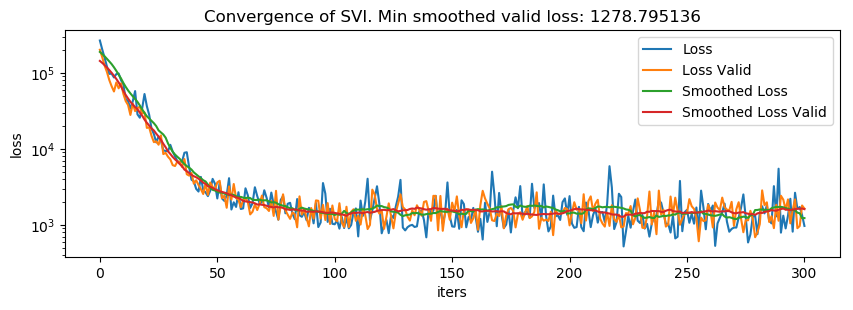

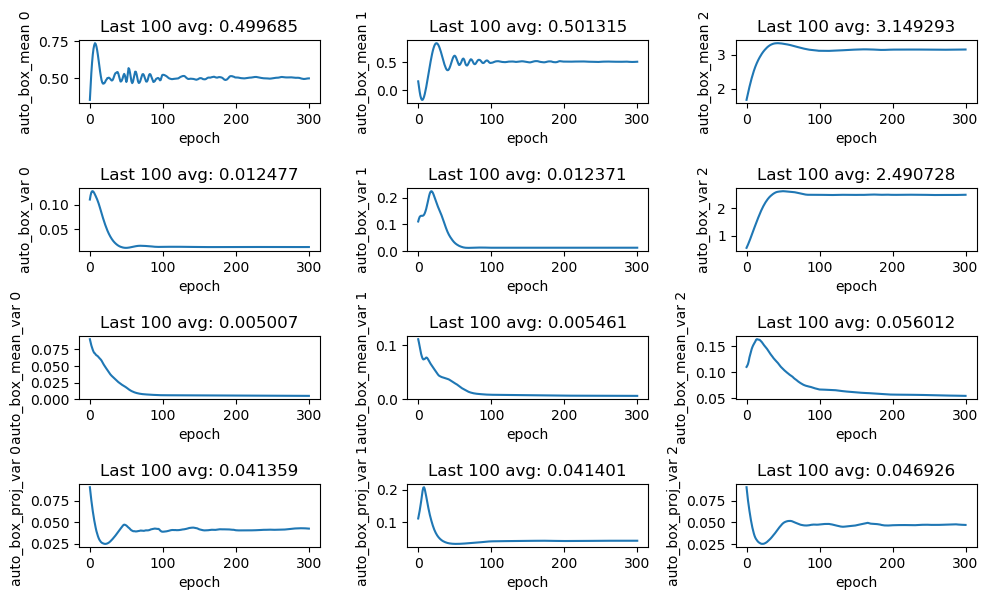

In [158]:
import scipy as sp
import scipy.ndimage
start_epoch = 0
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
range_fixed_losses = losses[start_epoch:] - np.min(losses[start_epoch:])*0
range_fixed_losses_valid = losses_valid[start_epoch:] - np.min(losses_valid[start_epoch:])*0
plt.plot(range_fixed_losses, label="Loss")
plt.plot(range_fixed_losses_valid, label="Loss Valid")
plt.xlabel('iters')
plt.ylabel('loss')
#plt.ylim(-12500, 20000)
plt.yscale('log')

def smooth(y, box_pts):
    # Kind of shitty gaussian kernel
    ax = np.arange(-box_pts//2 + 1., box_pts // 2 + 1.)
    kernel = np.exp(-ax**2 / (box_pts**2))
    kernel /= np.sum(kernel)
    y_smooth = sp.ndimage.convolve(y, kernel, mode='nearest')
    return y_smooth
plt.plot(smooth(range_fixed_losses, 20)[start_epoch:], label="Smoothed Loss")
smoothed_range_fixed_losses_valid = smooth(range_fixed_losses_valid, 20)[start_epoch:]
plt.plot(smoothed_range_fixed_losses_valid, label="Smoothed Loss Valid")
plt.title('Convergence of SVI. Min smoothed valid loss: %f' % np.min(smoothed_range_fixed_losses_valid));
plt.legend()

plt.figure(figsize=(10,6), dpi=100).set_facecolor('white')
keys = ["auto_box_mean", "auto_box_var", "auto_box_mean_var", "auto_box_proj_var"]
fit_vals = {}
n_plots = len(keys)
for i, key in enumerate(keys):
    data_across_epochs = np.vstack(snapshots[key])
    for k in range(3):
        plt.subplot(n_plots, 3, i*3+k+1)
        plt.plot(np.arange(start_epoch, data_across_epochs.shape[0]), data_across_epochs[start_epoch:, k])
        plt.xlabel('epoch')
        plt.ylabel(key + " %d" % k)
        plt.title("Last 100 avg: %f" % data_across_epochs[-100:, k].mean())
    fit_vals[key] = data_across_epochs[-100:].mean(axis=0)
plt.tight_layout()

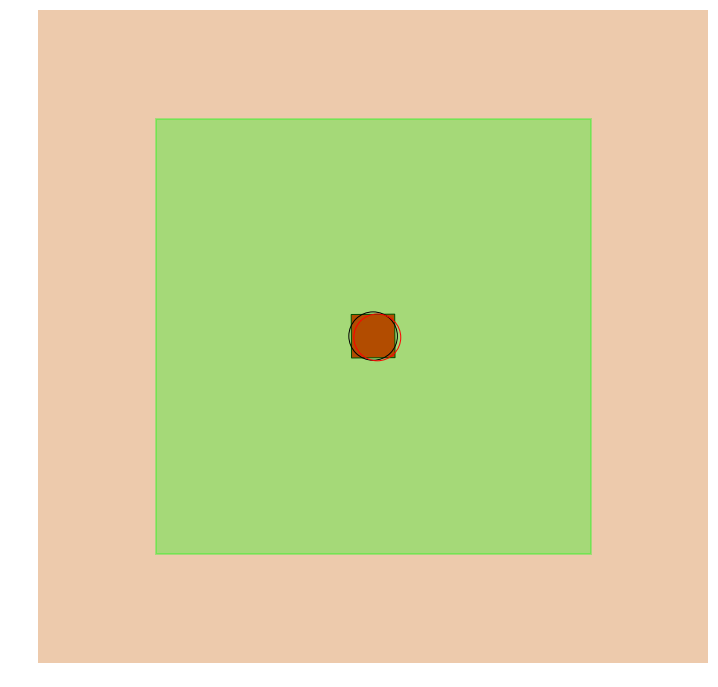

In [157]:
from matplotlib.patches import Ellipse
plt.figure().set_size_inches(12, 12)


data = vectorize_environments(environments["valid"]).detach().numpy()
real_vals = {}
real_vals["box_mean"] = np.mean(data, axis=0)
real_vals["box_var"] = np.square(np.std(data, axis=0))

env = {"n_objects": 1}
for k in range(1):
    object_name = "box"
    env["obj_%04d" % k] = {"class": "small_box", "pose": fit_vals["auto_" + object_name + "_mean"]}
# One object of each class, right at its mean
draw_environment(env, plt.gca())
# And draw ellipses
object_name = "box"
var = fit_vals["auto_" + object_name + "_var"]
mean = fit_vals["auto_" + object_name + "_mean"]
lambda_ = np.sqrt(var)
ell = Ellipse(xy=mean[0:2],
              width=lambda_[0], height=lambda_[1],
              color='black')
ell.set_facecolor('none')
plt.gca().add_artist(ell)

var = real_vals[object_name + "_var"]
mean = real_vals[object_name + "_mean"]
lambda_ = np.sqrt(var)
ell = Ellipse(xy=mean[0:2],
              width=lambda_[0], height=lambda_[1],
              color='red')
ell.set_facecolor('none')
plt.gca().add_artist(ell)
plt.show()

In [ ]:
plt.figure().set_size_inches(12, 12)
print "Selection of example environments, with our understanding of the pre-projection locations labeled"
N = 5
data = vectorize_environments(environments["valid"])

if not use_amortization:
    pre_poses = [pyro.param("auto_box_%d_pre_poses" % k).cpu().detach().numpy() for k in range(2)]
for i in range(N):
    for j in range(N):
        env_i = i*N+j+1
        plt.subplot(N, N, env_i)
        draw_environment(environments["valid"][env_i], plt.gca())
        for k in range(2):
            if use_amortization:
                mean = inference_module(data[env_i, (6*k):(6*k+6)])
            else:
                mean = pre_poses[k][env_i, 0:2]
            ell = Ellipse(xy=mean[0:2],
                          width=0.05, height=0.05,
                          color='yellow')
            ell.set_facecolor('none')
            plt.gca().add_artist(ell)

plt.tight_layout()

In [ ]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data={
            "box_mean": pyro.param("auto_box_mean"),
            "box_var": pyro.param("auto_box_var")})()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [ ]:
# MCMC as an alternative inference mechanism

from pyro.infer.mcmc import HMC, MCMC, NUTS
from pyro.infer import EmpiricalMarginal

hmc_kernel = NUTS(model)
# Struggles a *lot* with larger sample sizes. 20-50 seems like reasonable range.
# Noisy projection doesn't seem critical...
# From a few runs, it looks like the empirical mean estimates are better
# when I'm using more samples and smaller subsample size. But I suspect
# that's not really very true, as it generally varies significantly run-to-run
# for ~500 sample territory.
# But when the mean estimate is bad, the variance estimate is really high --
# so the empirical distribution over sample locations still looks great. Beyond
# the power of having projection in the loop...
# I'll need to try this on a "harder" distribution...
# Update: looks like I broke this with recent changes, with include
# switching to a multivariate normal prior for the box center prior., and switching
# on the increased logprob penalty for samples out in infeasible space... oops...
# I'll stick with SVI...
mcmc_run = MCMC(hmc_kernel, num_samples=900, warmup_steps=100).run(data, subsample_size=10, use_projection=True, noisy_projection=False
                                                                )

In [ ]:
# do some analysis of that when it comes out
posterior_box_mean = EmpiricalMarginal(mcmc_run, 'box_mean')
print "Box mean, empirical: ", posterior_box_mean.mean, " +/- ", posterior_box_mean.variance
posterior_box_var = EmpiricalMarginal(mcmc_run, 'box_var')
print "Box var, empirical: ", posterior_box_var.mean, " +/- ", posterior_box_var.variance
print "I don't trust those variance estimates..."

def plot_empirical_marginal(ax, empirical_marginal, subind_x, subind_y):
    datapoints = empirical_marginal._samples.detach().numpy()
    plt.scatter(datapoints[:, :, subind_x].flatten(), datapoints[:, :, subind_y].flatten())
    plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_0_pose'), 0, 1)
plt.title("Scene 0 pose samples")
plt.subplot(2, 1, 2)
plt.title("Scene 1 pose samples")
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_1_pose'), 0, 1)
plt.tight_layout();